In [11]:
#this is data about population names (males here)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [13]:
#First a bit of cleaning, non-numeric types can be problematic later
df=pd.read_csv('fem.csv')
df = df.replace('*',0)
df = df.rename(columns={cname: int(cname.strip('J_')) if 'J_' in cname else cname
        for cname in df.columns})
df = df.set_index('firstname')
df = df.apply(lambda col:col.astype(int))
df.head(5)

,Total,1908,1909,1910,1911,1912,1913,1914,1915,1916,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
firstname,,,,,,,,,,,,,,,,,,,,,
Jean,14896,0,0,0,0,0,0,0,0,0,...,21,15,9,17,13,12,13,10,10,14
Michel,12123,0,0,0,0,0,0,0,0,0,...,5,8,5,6,6,0,6,0,3,3
Pierre,11910,0,0,0,0,0,0,0,0,3,...,25,14,13,12,14,11,7,8,14,18
Daniel,11842,0,0,0,0,0,0,0,0,0,...,53,48,53,62,61,38,55,49,39,42
David,10772,0,0,0,0,0,0,0,0,0,...,93,88,95,107,95,97,77,79,60,61


In [3]:
#PART 2: FIND WHICH NAMES ARE DISAPPEARING / GROWING TROUGHOUT THE CENTURY
#proposition 1: find the regression coefficient for each name?

### Check noise structure

In [4]:
## If you want to learn more about this: http://www.ats.ucla.edu/stat/r/dae/nbreg.htm

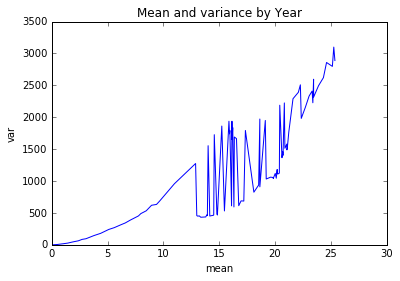

In [5]:
byYear = pd.DataFrame({'mean':df.mean(axis=0)[1:],'var':df.var(axis=0)[1:]}).sort_values(by='mean')
plt.plot(byYear['mean'],byYear['var'])
plt.xlabel('mean')
plt.ylabel('var')
plt.title('Mean and variance by Year')

 ### Check shape (e.g. mean)

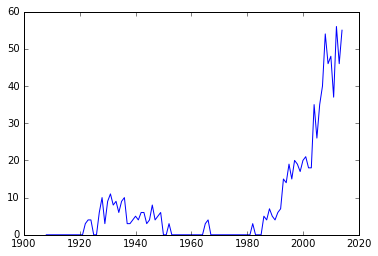

In [19]:
name = 'Jules'
plt.plot(df.loc[name,:][1:].index.values, df.loc[name,:][1:])

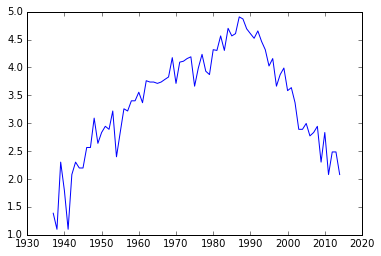

In [7]:
#Might be quadratic in a log-scale
plt.plot(df.loc[name,:][1:].index.values,np.log(df.loc[name,:][1:]))

# The Fit

### For one person (defined above in variable name)

In [390]:
nameSeries = df.loc[name,:][1:]
#First occurence of the name
first_occ = nameSeries[nameSeries>0].index[0]
last_occ = nameSeries[nameSeries>0].index[-1]
nameSeries = nameSeries[nameSeries.index>=first_occ]
nameSeries = nameSeries[nameSeries.index<=last_occ]

In [391]:
dataName = pd.DataFrame({'count': nameSeries.values.astype(int) + 1,
     'year':nameSeries.index.values.astype(int),
     'year2':np.power(nameSeries.index.values.astype(int),2)})

In [392]:
method = sm.families.NegativeBinomial(link=sm.families.links.log)
mod = smf.glm('count~year+year2', data=dataName,
                  family=method,).fit(method='bfgs',maxiter=100)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                   85
Model:                            GLM   Df Residuals:                       82
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                  0.145903577618
Method:                          IRLS   Log-Likelihood:                -366.20
Date:                Fri, 17 Jun 2016   Deviance:                       10.553
Time:                        06:00:47   Pearson chi2:                     12.0
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -6479.9112    321.623    -20.148      0.000     -7110.280 -5849.543
year           6.5505      0.326     20.090      0.000         5.911     7.190
year2         -0.0017   8.26e-05    -20.021      0.000        -0.002    -0.001
==============================================================================
"""

In [286]:
reg_cff = mod.params[mod.pvalues<=0.05][['year','year2']]
pd.DataFrame({'name':[name],'year':[reg_cff.year],'year2':[reg_cff.year2]})

,name,year,year2
0,Michael,6.550546,-0.001654


## What names were popular recently?

In [15]:
from functools import partial

def get_par_inf(recent,row):
    
    nameSeries = row[1:]
    if recent:
        first_occ = nameSeries[nameSeries>0].index[0]
        nameSeries = nameSeries[nameSeries.index>=first_occ]
    else:
        last_occ = nameSeries[nameSeries>0].index[-1]
        nameSeries = nameSeries[nameSeries.index<=last_occ]
      
    dataName = pd.DataFrame({'count': nameSeries.values.astype(int) + 1,
     'year':nameSeries.index.values.astype(int),
     'year2':np.power(nameSeries.index.values.astype(int),2)
                            })
    method = sm.families.NegativeBinomial(link=sm.families.links.log)
    mod = smf.glm('count~year+year2', data=dataName,
                  family=method,).fit(method='bfgs',maxiter=100)
    reg_cff = mod.params[mod.pvalues<=0.05][['year','year2']]
    return pd.Series([row.name,reg_cff.year,reg_cff.year2],index=['name','year','year2'])


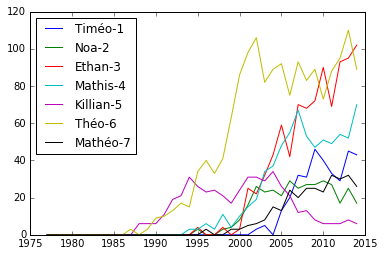

In [21]:
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

start = 70
results_reg = df.apply(partial(get_par_inf,True),axis=1).reset_index(level=[0],drop=True)
top_recent = results_reg.sort_values(by=['year','year2'],ascending=[False,False]).head(7)

for i,nm in enumerate(top_recent['name'].values):
    plt.plot(df.loc[nm,:][start:].index.values, df.loc[nm,:][start:].values, label='%s-%d'%(nm,i+1))
plt.legend(loc='best')

## Which names are disappearing?

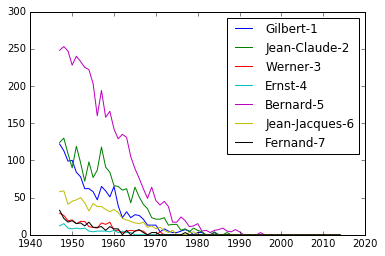

In [22]:
results_reg = df.apply(partial(get_par_inf,False),axis=1).reset_index(level=[0],drop=True)
top_old = results_reg.sort_values(by=['year','year2'],ascending=[False,False]).head(7)

for i,nm in enumerate(top_old['name'].values):
    plt.plot(df.loc[nm,:][40:].index.values, df.loc[nm,:][40:].values, label='%s-%d'%(nm,i+1))
plt.legend(loc='best')

## Benchmark (bfs.admin.ch)

In [14]:
top_bfs = ['David','Nicolas','Alexandre','Julien']